This is a notebook to recreate Figure 1 of Lamb, Taylor & Siemens 2023.  This notebook creates $p$-$p$ plots of the code.

In [8]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt
import glob
from chainconsumer import ChainConsumer
import pickle
from ceffyl import Ceffyl, models
from enterprise.signals import parameter, gp_priors as gpp
from enterprise_extensions.model_utils import get_tspan
from scipy.stats import percentileofscore
import la_forge.core as co

# ACCRE-specific import to load correct latex file
## COMMENT OUT AS REQUIRED
import os
os.environ["PATH"] += os.pathsep + '/home/lambwg/latex/bin/x86_64-linux' 

In [2]:
# setup default plotting code
plt.rcParams.update(plt.rcParamsDefault)
with open('/home/lambwg/ng15_rcparams.json', 'rb') as fin:
    plt.rcParams.update(json.load(fin))

# Calculate $p$-$p$ values

Calculate percentile of score of injected values in analysis posterior

In [5]:
# injected characteristics
inj = np.array([np.loadtxt(f'/home/lambwg/GFL/middleton21/simulations/realisations/realisation_{ii}/injected_values.txt')
                for ii in range(100)])

full uncorrelated likelihood

In [16]:
# free spec
pAm2a, pgm2a = np.zeros(100), np.zeros(100)
for ii in range(100):
    
    # load chain
    c0 = co.Core(corepath=f'/data/taylor_group/william_lamb/GFL/middleton21/m2a_10f/realisation_{ii}/chain.core')
    
    # find percentile
    pAm2a[ii] = percentileofscore(c0('log10_A_gw'), inj[ii,0])
    pgm2a[ii] = percentileofscore(c0('gamma_gw'), inj[ii,1])

PTA free spectrum refit

In [10]:
# free spec
pA, pg = np.zeros(100), np.zeros(100)
for ii in range(100):
    
    # load chain
    c0 = co.Core(corepath=f'/data/taylor_group/william_lamb/GFL/middleton21/freespec10f/realisation_{ii}/fftkde_10k_2/refits/10fplCP/chain.core')
    
    # find percentile
    pA[ii] = percentileofscore(c0('log10_A_gw'), inj[ii,0])
    pg[ii] = percentileofscore(c0('gamma_gw'), inj[ii,1])

GFL Lite

In [11]:
# gfl lite
pAgflite, pggflite = np.zeros(100), np.zeros(100)
for ii in range(100):
    
    # load chain
    c0 = co.Core(corepath=f'/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_{ii}/fftkde_10000_final/refits/10fplCP/chain.core')
    
    # find percentile
    pAgflite[ii] = percentileofscore(c0('log10_A_gw'), inj[ii,0])
    pggflite[ii] = percentileofscore(c0('gamma_gw'), inj[ii,1])

#####  Calculate CDFs of the percentile of scores

In [17]:
# sort scores
pAm2a, pgm2a = np.sort(pAm2a)/100, np.sort(pgm2a)/100
pA, pg = np.sort(pA)/100, np.sort(pg)/100 
pAgflite, pggflite = np.sort(pAgflite)/100, np.sort(pggflite)/100

In [18]:
# full likelihood
q = np.linspace(0, 1, 100)
cdfAm2a, cdfgm2a = np.zeros(100), np.zeros(100)
for i in range(len(q)):
    cdfAm2a[i] = len(np.where(pAm2a < q[i])[0])/100
    cdfgm2a[i] = len(np.where(pgm2a < q[i])[0])/100

In [13]:
# free spec
q = np.linspace(0, 1, 100)
cdfA, cdfg = np.zeros(100), np.zeros(100)
for i in range(len(q)):
    cdfA[i] = len(np.where(pA < q[i])[0])/100
    cdfg[i] = len(np.where(pg < q[i])[0])/100

In [14]:
# GFL Lite
q = np.linspace(0, 1, 100)
cdfAgflite, cdfggflite = np.zeros(100), np.zeros(100)
for i in range(len(q)):
    cdfAgflite[i] = len(np.where(pAgflite < q[i])[0])/100
    cdfggflite[i] = len(np.where(pggflite < q[i])[0])/100

# Plot!

CDF vs percentiles...

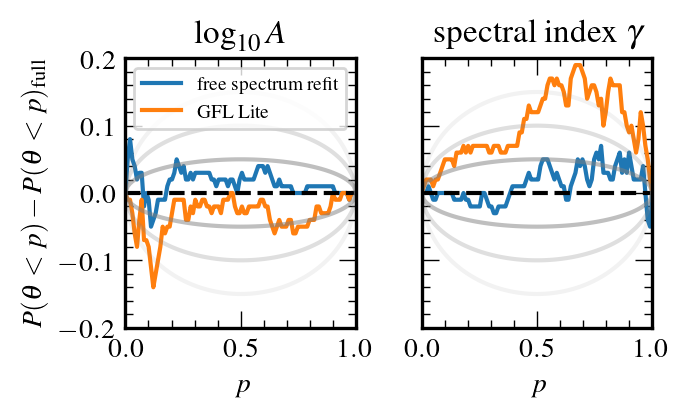

/tmp/ipykernel_44094/2269337621.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('../plots/ppplots.pdf',


In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, tight_layout=True,
                               sharex=True, sharey=True)
q = np.linspace(0, 1, 100)
sigma = np.sqrt(q*(1-q)/100)

ax1.set_xlim(0, 1)
ax1.set_ylim(-0.2, 0.2)

ax1.plot(q, cdfA-cdfAm2a, label='free spectrum refit', c='C0')
ax2.plot(q, cdfg-cdfgm2a)

ax1.plot(q, cdfAgflite-cdfAm2a, label='GFL Lite', c='C1')
ax2.plot(q, cdfggflite-cdfgm2a)

ax1.axhline(0, ls='--', c='k')
ax2.axhline(0, ls='--', c='k')

ax1.set_ylabel(r'$P(\theta<p)$')
ax1.set_xlabel('$p$',)
ax2.set_xlabel('$p$',)
ax1.set_ylabel(r'$P(\theta<p)-P(\theta<p)_\mathrm{full}$',)

ax1.set_title('$\log_{10}A$',)
ax2.set_title('spectral index $\gamma$',)

for ii, alpha in zip([1,2,3], [0.5, 0.25, 0.1]):
    ax1.plot(q, ii*sigma, color='grey', alpha=alpha)
    ax2.plot(q, ii*sigma, color='grey', alpha=alpha)
    
    ax1.plot(q, -ii*sigma, color='grey', alpha=alpha)
    ax2.plot(q, -ii*sigma, color='grey', alpha=alpha)
    
ax1.legend()
plt.show();
fig.savefig('../plots/ppplots.pdf',
            dpi=400, bbox_inches='tight', rasterize=True);